## Загружаем необходимые библиотеки

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [4]:
#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [5]:
train_df = pd.read_csv('HW_train_main_data.csv')
test_df = pd.read_csv('HW_test_main_data.csv')
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,apartment condition,sub_area,price
0,30392,2014-12-30,60,36.0,6.0,9.0,1.0,1974.0,3.0,5.0,3.0,9,9711800.0
1,36540,2013-06-28,44,29.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,19,6643200.0
2,94669,2013-09-15,62,60.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,80,5698300.0
3,17531,2013-12-13,33,18.0,4.0,9.0,1.0,1970.0,1.0,6.0,2.0,15,5055000.0
4,32159,2014-02-13,37,14.0,1.0,17.0,1.0,1991.0,1.0,1.0,2.0,74,5425000.0


## 10 самых дорогих квартир

In [7]:
top_price_flat = train_df.sort_values(by='price', ascending=False).iloc[:10]['id'].values.tolist()
top_price_flat

[85073, 14154, 88100, 78059, 91175, 45584, 95572, 63901, 92747, 40136]

## Зависимость средней стоимости квартиры от года и месяца продаж

In [8]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

In [9]:
train_df['year'] = train_df['timestamp'].dt.year
train_df['month'] = train_df['timestamp'].dt.month
train_df['month_year'] = train_df['month'].astype(str) + '_' + train_df['year'].astype(str)

In [10]:
agg_1 = train_df.sort_values(['year', 'month']).groupby(['year', 'month']).price.mean().reset_index()

In [11]:
agg_1.head()

,year,month,price
0,2011,9,7.001000e+06
1,2011,10,5.942623e+06
2,2011,11,6.044407e+06
3,2011,12,6.459589e+06
4,2012,1,6.396341e+06


In [14]:
agg_1['year_month'] = agg_1['year'].astype(str) +'_'+ agg_1['month'].astype(str)
agg_1.head()

,year,month,price,year_month
0,2011,9,7.001000e+06,2011_9
1,2011,10,5.942623e+06,2011_10
2,2011,11,6.044407e+06,2011_11
3,2011,12,6.459589e+06,2011_12
4,2012,1,6.396341e+06,2012_1


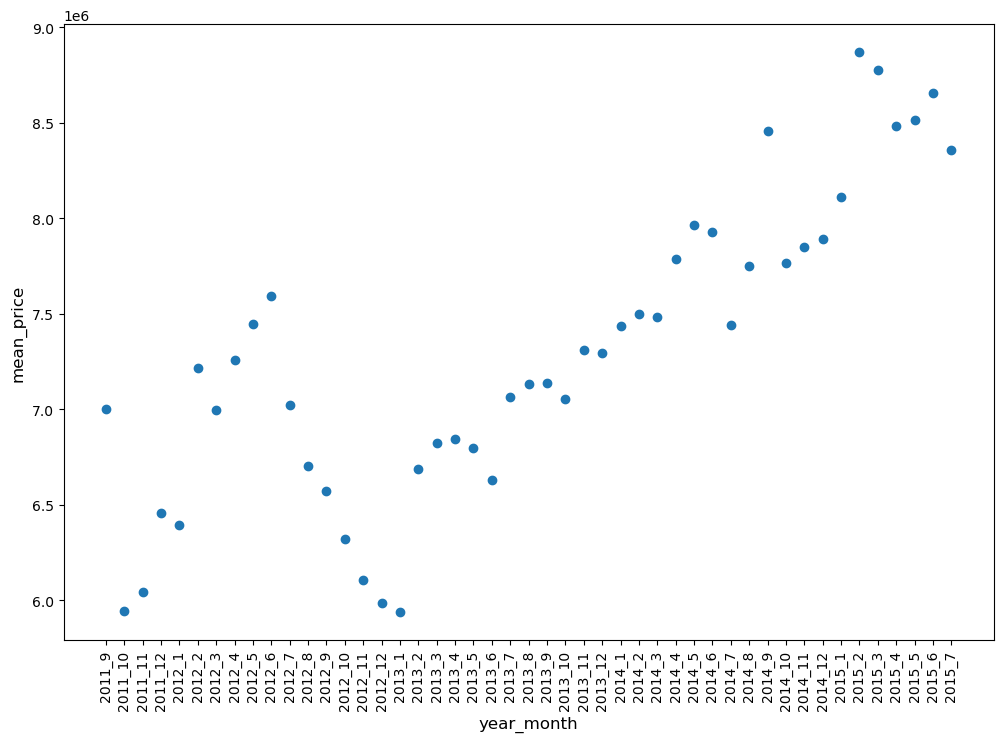

In [15]:
plt.figure(figsize = (12,8))
plt.scatter(x = 'year_month', y = 'price', data = agg_1)
plt.ylabel('mean_price', fontsize =12)
plt.xlabel('year_month', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

In [18]:
train_df['price_rank'] = train_df.groupby('month_year')['price'].rank(method="first", ascending=False)
ind_with_max_price = train_df[train_df['price_rank'] == 1].sort_values(by=['year', 'month']).index.tolist()
ind_with_max_price

[22408,
 28566,
 24188,
 27279,
 20316,
 27461,
 8417,
 26644,
 18117,
 10035,
 26274,
 26321,
 9030,
 16898,
 28806,
 7537,
 15912,
 3163,
 26225,
 3767,
 27095,
 14807,
 24097,
 20799,
 20649,
 10213,
 8788,
 20082,
 6981,
 1740,
 7055,
 12729,
 5582,
 15217,
 18599,
 5942,
 28868,
 25278,
 13329,
 2526,
 9340,
 14321,
 5829,
 6705,
 7755,
 12483,
 2014]

### Для месяца-года находим индексы самых дорогих квартиры

In [19]:
train_df.groupby(['year', 'month'])['price'].max().reset_index() \
    .merge(train_df, how='left', on=['year', 'month','price']) \
    [['year','month', 'price','id']].id.values.tolist()

[93255,
 39837,
 33763,
 42921,
 86122,
 59279,
 84792,
 80442,
 85073,
 53400,
 80358,
 38059,
 35501,
 45584,
 38931,
 18753,
 20881,
 63901,
 78059,
 38846,
 14154,
 84443,
 42092,
 59134,
 60348,
 85298,
 18085,
 20432,
 55606,
 98631,
 68847,
 43686,
 58882,
 91175,
 49814,
 73610,
 34194,
 75296,
 56862,
 95044,
 53674,
 95572,
 88100,
 67613,
 40136,
 72354,
 45373]

### Построим boxplot для цены пар месц-год

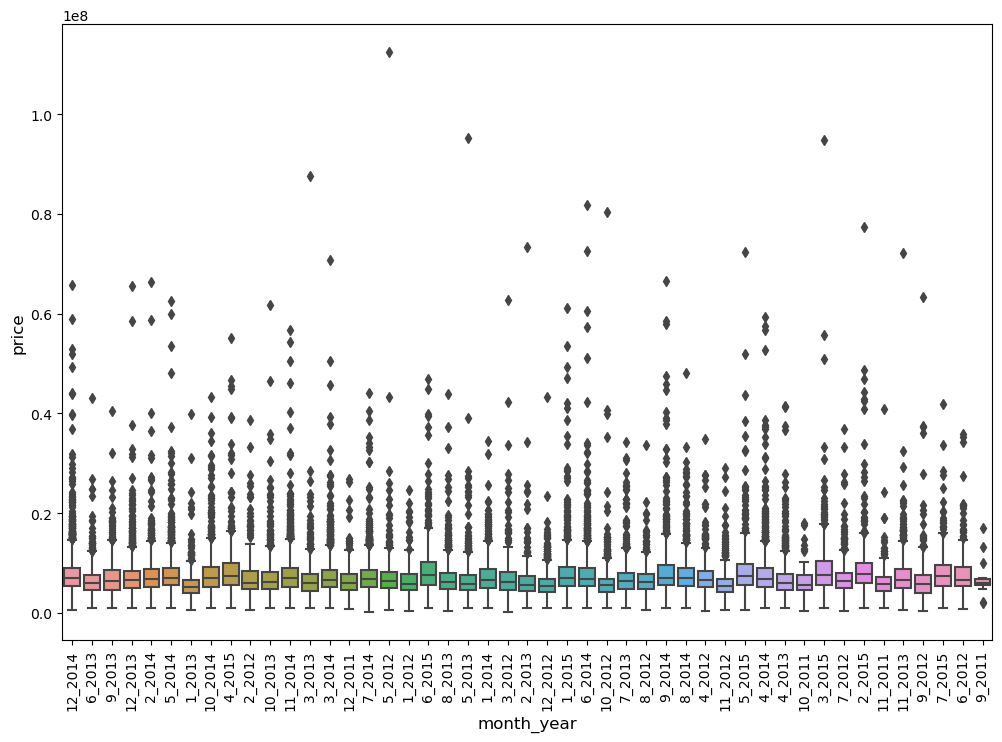

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(x='month_year', y='price', data=train_df)
plt.ylabel('price', fontsize=12)
plt.xlabel('month_year', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Найдите "id" 5 самых больших квартир

In [21]:
top_5_flat = train_df.sort_values(by='full_sq', ascending=False).iloc[:5]['id'].values.tolist()
top_price_flat

[85073, 14154, 88100, 78059, 91175, 45584, 95572, 63901, 92747, 40136]

### Количество пропусков

In [23]:
life_sq_nan_cnt = train_df['life_sq'].isna().sum()
life_sq_nan_cnt

6065

### Заполним средним значением пропуски

In [26]:
life_sq_mean = train_df['life_sq'].mean()
train_df['life_sq'] = train_df['life_sq'].fillna(life_sq_mean)

### Сохранить коэффициенты корреляции Пирсона между (price, full_sq) и (price, life_sq без пропусков)

In [28]:
corr = train_df[['price','full_sq','life_sq']].corr().iloc[0,1:].values.tolist()
corr

[0.3371130874205802, 0.38005124559108316]

In [30]:
with open('./part1.csv','w') as f:
    f.write(','.join(map(str, top_price_flat)))
    f.write('\n')
    f.write(','.join(map(str, ind_with_max_price)))
    f.write('\n')
    f.write(','.join(map(str, top_5_flat)))
    f.write('\n')
    f.write(str(life_sq_nan_cnt))
    f.write('\n')
    f.write(', '.join(map(str, corr)))